In [134]:

import numpy as np
import cv2
import matplotlib.pyplot as plt
from scipy.ndimage import maximum_filter
from skimage.feature import peak_local_max
from skimage.filters import gaussian
from ultralytics import SAM
import os
import glob


In [141]:

# Usage
image = "merged_scan_51_113_perspective"

anomaly_mask = np.load(f"results/anomaly_masks/exp_train400_coreset0.3/{image}_mask.npy")
original_image_path = f"masonry_dataset/wall/test/defect/{image}.png"
original_image = cv2.imread(original_image_path)


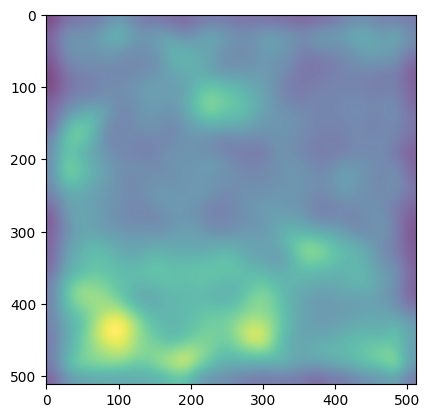

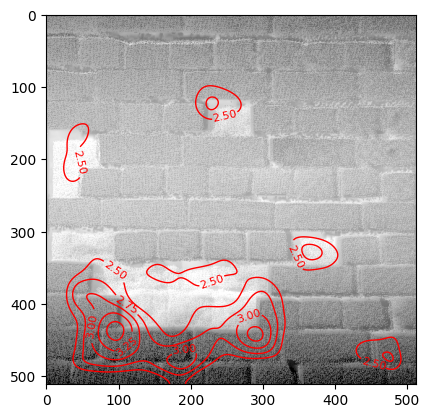

In [162]:
plt.imshow(anomaly_mask, alpha=0.7)
plt.show()

# Show contour lines at different anomaly score levels
plt.imshow(original_image)  # Your background image
contours = plt.contour(anomaly_mask, levels=[2.5, 2.75, 3.0, 3.25, 3.5], colors='red', linewidths=1)
plt.clabel(contours, inline=True, fontsize=8)  # Add labels showing the levels
plt.show()


In [163]:
import numpy as np
from matplotlib.path import Path

def get_contour_centroids(contours, image_shape):
    """
    Get center of mass (centroid) for each contour - simple and fast

    Args:
        contours: matplotlib contour object from plt.contour()
        image_shape: (height, width) of the original image

    Returns:
        np.array: Array of [x, y] coordinates of centroids
    """
    centroids = []

    for level_idx in range(len(contours.levels)):
        level_paths = contours.collections[level_idx].get_paths()

        for path in level_paths:
            if len(path.vertices) < 3:
                continue

            vertices = path.vertices

            # Get bounding box
            x_min, y_min = np.floor(vertices.min(axis=0)).astype(int)
            x_max, y_max = np.ceil(vertices.max(axis=0)).astype(int)

            # Clamp to image bounds
            x_min = max(0, x_min)
            y_min = max(0, y_min)
            x_max = min(image_shape[1], x_max)
            y_max = min(image_shape[0], y_max)

            if x_max <= x_min or y_max <= y_min:
                continue

            # Create all points in bounding box
            xx, yy = np.meshgrid(np.arange(x_min, x_max), np.arange(y_min, y_max))
            points = np.column_stack([xx.ravel(), yy.ravel()])

            # Find points inside contour
            path_obj = Path(vertices)
            inside_mask = path_obj.contains_points(points)
            inside_points = points[inside_mask]

            if len(inside_points) > 0:
                # Simple center of mass - just mean of all points
                centroid_x = np.mean(inside_points[:, 0])
                centroid_y = np.mean(inside_points[:, 1])
                centroids.append([centroid_x, centroid_y])

    return np.array(centroids)


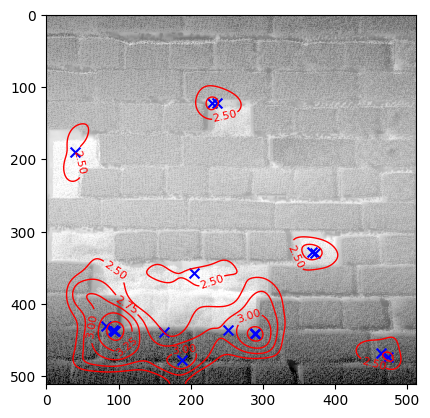

In [164]:
import numpy as np
import cv2
from matplotlib.path import Path

# Usage with your existing contours
centroids = get_contour_centroids(contours, anomaly_mask.shape)

# Visualize
plt.imshow(original_image)
plt.scatter(centroids[:, 0], centroids[:, 1],
           c='blue', s=50, marker='x')
contours = plt.contour(anomaly_mask, levels=[2.5, 2.75, 3.0, 3.25, 3.5], colors='red', linewidths=1)
plt.clabel(contours, inline=True, fontsize=8)  # Add labels showing the levels
plt.show()




0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 18, 1 19, 1 20, 1 21, 1 22, 1 23, 1 24, 4548.0ms
Speed: 5.4ms preprocess, 4548.0ms inference, 1.3ms postprocess per image at shape (1, 3, 1024, 1024)
Results saved to /home/tom_hill_joltsynsor_com/patchcore-inspection/runs/segment/predict20


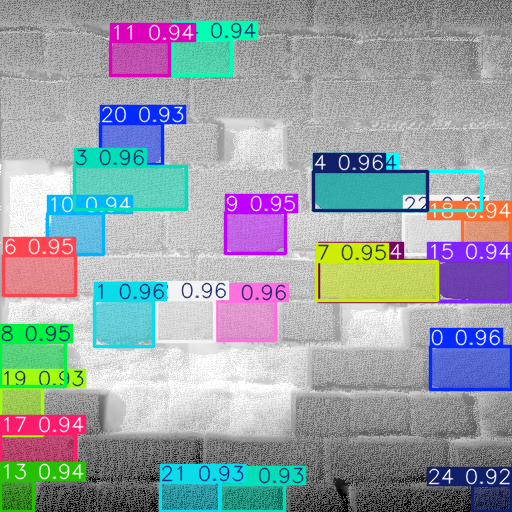

In [170]:
from ultralytics import SAM

segment_everything = SAM("sam2.1_b.pt")
results = segment_everything(original_image, save=True, show_boxes=False)
results[0].show()


In [93]:
from ultralytics import SAM
import cv2
import numpy as np
import matplotlib.pyplot as plt

sam_model = SAM('sam2_l.pt')


0: 512x512 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 71.6ms
Speed: 1.6ms preprocess, 71.6ms inference, 0.8ms postprocess per image at shape (1, 3, 512, 512)
Results saved to /home/tom_hill_joltsynsor_com/patchcore-inspection/runs/segment/predict17


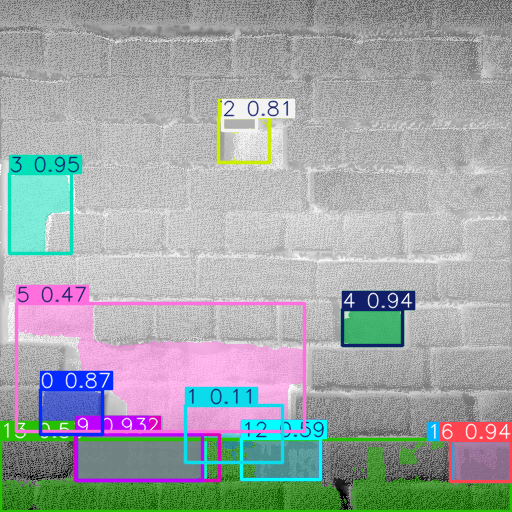

In [171]:
def run_sam_on_hotspots(image_path, maxima_points):
    """Simple function to run SAM on hotspot points"""

    # Load image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert points to numpy array
    points = np.array(maxima_points)

    labels = np.ones(len(maxima_points))

    # Run SAM
    results = sam_model(image_rgb, points=points, labels=labels, imgsz=512, save=True)

    return image_rgb, results

_, results = run_sam_on_hotspots(original_image_path, centroids)
results[0].show()